In [1]:
import numpy as np
import tensorflow as tf
from scipy.interpolate import CubicSpline

2024-09-19 11:32:39.157039: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-19 11:32:39.158643: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-19 11:32:39.180880: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-19 11:32:39.180914: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-19 11:32:39.180938: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

In [2]:
class NaturalCubicSpline(tf.keras.layers.Layer):
    def __init__(self, x, y=None, **kwargs):
        """
        Initialize with x (data points) and y (TensorFlow Variables).
        x: 1D numpy array of shape (n,) for the interpolation points
        y: TensorFlow variable of shape (n,) for the values at the interpolation points
        """
        super().__init__(**kwargs)
        assert np.all(np.diff(x) > 0.0)
        # NOTE: To make the x trainable we would need to also enforce their ordering somehow
        self.x = self.add_weight(
            shape=x.shape,
            name="x",
            trainable=False,
            initializer=tf.constant_initializer(x),
        )
        self.y = self.add_weight(
            shape=x.shape,
            name="y",
            trainable=True,
            initializer=tf.zeros_initializer()
            if y is None
            else tf.constant_initializer(y),
        )
        self.n = len(x)

        # Compute the distances between the x points (h_i = x_{i+1} - x_i)
        # NOTE: no equivalent for np.diff in tensorflow
        self.h = self.x[1:] - self.x[:-1]

    def compute_coefficients(self):
        """
        Compute the coefficients of the natural cubic spline.
        """
        # Compute the matrix system to solve for the second derivatives
        A = self._construct_tridiagonal_matrix()
        b = self._construct_rhs()

        # Solve for the second derivatives (M)
        # TODO refactor to use diagonals_format = compact
        M = tf.linalg.tridiagonal_solve(A, b, diagonals_format="matrix")
        print(M.shape)

        return M

    def _construct_tridiagonal_matrix(self):
        """
        Construct the tridiagonal matrix for the natural cubic spline system.
        """

        return (
            tf.linalg.diag(
                tf.concat(
                    [tf.ones((1,)), 2 * (self.h[:-1] + self.h[1:]), tf.ones((1,))],
                    axis=0,
                )
            )
            + tf.linalg.diag(tf.concat([tf.zeros((1,)), self.h[1:]], axis=0), k=1)
            + tf.linalg.diag(tf.concat([self.h[:-1], tf.zeros((1,))], axis=0), k=-1)
        )

    def _construct_rhs(self):
        """
        Construct the right-hand side vector b for the natural cubic spline system.
        """
        y = self.y
        h = self.h
        b = tf.concat(
            [
                tf.zeros((1,)),
                6 * ((y[2:] - y[1:-1]) / h[1:] - (y[1:-1] - y[:-2]) / h[:-1]),
                tf.zeros((1,)),
            ],
            axis=0,
        )

        return b

    @tf.function(
        input_signature=(
            tf.TensorSpec(shape=(None, 1), dtype=tf.keras.backend.floatx()),
        )
    )
    def call(self, x_new):
        """
        Evaluate the spline values at r points using the coefficients.
        """
        x_new = tf.squeeze(x_new)
        M = self.compute_coefficients()

        # Find the interval where each x_new belongs
        idx = tf.searchsorted(self.x, x_new) - 1
        # To enable extrapolation use the edge polynomials whenever
        # the index is < 0 or > n - 1.
        idx = tf.clip_by_value(idx, 0, self.n - 2)

        # Get corresponding h values for each x_new
        h = tf.gather(self.h, idx)

        # Compute spline components
        a = (tf.gather(self.x, idx + 1) - x_new) / h
        b = (x_new - tf.gather(self.x, idx)) / h

        # Compute spline value using the natural cubic spline formula
        spline_value = (
            a * tf.gather(self.y, idx)
            + b * tf.gather(self.y, idx + 1)
            + ((a**3 - a) * tf.gather(M, idx) + (b**3 - b) * tf.gather(M, idx + 1))
            * (h**2)
            / 6
        )

        return tf.reshape(spline_value, (-1, 1))


(7,)


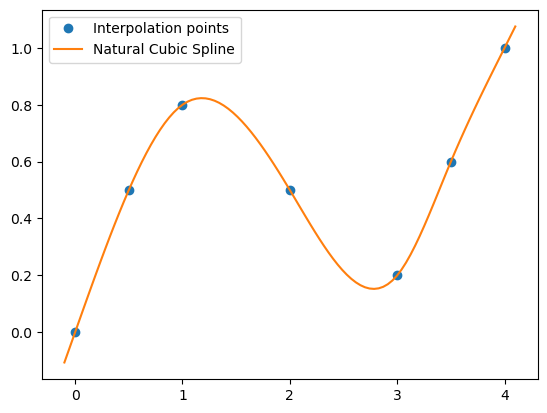

In [3]:
# Define x (interpolation points) and y (adjustable y-values)
x = np.array([0.0, 0.5, 1.0, 2.0, 3.0, 3.5, 4.0])

# Initialize y
y = np.array([0.0, 0.5, 0.8, 0.5, 0.2, 0.6, 1.0])[: len(x)]

# Create an instance of the NaturalCubicSpline
spline = NaturalCubicSpline(x, y)

# Define new x points where you want to evaluate the spline
x_fit = np.linspace(-0.1, 4.1, 100).reshape(-1, 1)
# x_fit = x.reshape(-1, 1)

# Compute the spline values
spline_values = spline(x_fit)
# print(spline_values.shape)

# Print or plot the results
import matplotlib.pyplot as plt

x_plot = np.linspace(-0.1, 4.1, 100).reshape(-1, 1)

plt.plot(x, spline.y.numpy(), "o", label="Interpolation points")
plt.plot(x_fit, spline_values.numpy(), label="Natural Cubic Spline")
plt.legend()
plt.show()


In [4]:
# Define a loss function (for example, a mean squared error against some target values)
# Target curve (just an example)
def target_fun(x):
    return np.sinc(x)


target_y = target_fun(x_fit)


# Loss: Mean squared error between the spline values and the target curve
def loss_fn():
    spline_values = spline(x_fit)
    return tf.reduce_mean(tf.square(spline_values - target_y))


# Use an optimizer to minimize the loss and adjust the y-values
optimizer = tf.optimizers.Adam(learning_rate=0.01)

# Training loop
for step in range(1000):
    optimizer.minimize(loss_fn, var_list=[w for w in spline.weights if w.trainable])

    if step % 100 == 0:
        print(f"Step {step}: Loss = {loss_fn().numpy()}")

# After training, the y-values should be adjusted
print("Adjusted y-values:", spline.y.numpy())


Step 0: Loss = 0.43230125308036804
Step 100: Loss = 0.011090850457549095
Step 200: Loss = 0.00047997795627452433
Step 300: Loss = 0.00040831492515280843
Step 400: Loss = 0.00040825639734975994
Step 500: Loss = 0.0004082565428689122
Step 600: Loss = 0.0004082565719727427
Step 700: Loss = 0.00040825651376508176
Step 800: Loss = 0.00040825651376508176
Step 900: Loss = 0.00040825651376508176
Adjusted y-values: [ 0.99605066  0.6644445  -0.03182098  0.00540185  0.02629619 -0.10432153
  0.00739105]


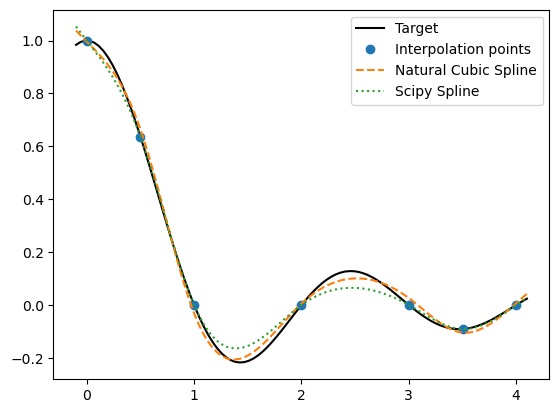

In [5]:
plt.plot(x_plot, target_fun(x_plot), "k", label="Target")
plt.plot(
    x,
    target_fun(x),
    "o",
    label="Interpolation points",
)

scipy_spline = CubicSpline(x, target_fun(x), bc_type="natural")
plt.plot(x_plot, spline(x_plot), "--", label="Natural Cubic Spline")
plt.plot(x_plot, scipy_spline(x_plot), ":", label="Scipy Spline")
plt.legend()
# plt.yscale("log")
plt.show()

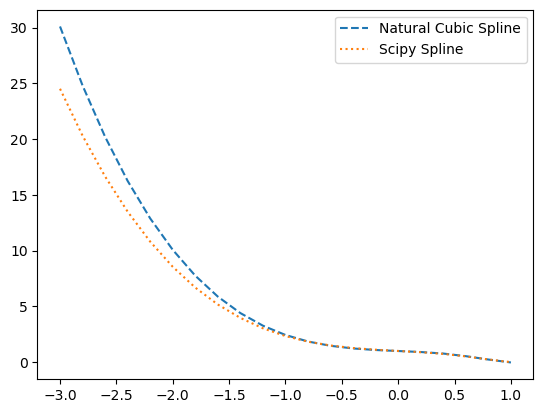

In [6]:
# Difference is because the TF implementation actually tries to fit the full range
# of x_new
x_extrap = np.linspace(-3, 1, 21).reshape(-1, 1)
plt.plot(x_extrap, spline(x_extrap), "--", label="Natural Cubic Spline")
plt.plot(x_extrap, scipy_spline(x_extrap), ":", label="Scipy Spline")
plt.legend()